<a href="https://colab.research.google.com/github/JungMinNoh/jungminnoh/blob/master/%EC%A0%90%ED%94%84_%ED%88%AC_%ED%8C%8C%EC%9D%B4%EC%8D%AC_6%EC%9E%A5(%ED%95%99%EC%8A%B5%EA%B4%80%EB%A0%A8%EA%B8%B0%EC%88%A0%EB%93%A4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번 장에서 다룰 주제는 
1. 가중치 매개 변수의 최적값을 탐색하는 최적화 방법, 
2. 가중치 매개변수 초깃값
3. 하이퍼 파라미터 설정방법 등 

신경망 학습에서 중요한 주제입니다. 

또한 오버피팅의 대응책인 가중치 감소와 드롭아웃등의 정규화 방법도 간략히 설명하고 구현해봅니다.    
  
마지막으로 최근 많은 연구에서 사용하는 배치 정규화도 짧게 알아봅니다.   
  
이번 장에서 설명하는 기법을 이용하면 신경망(딥러닝) 학습의 효율과 정확도를 높일 수 있습니다.


# 6.1 매개 변수 갱신

신경망 학습의 목적은 손실함수의 값을 가능한 한 낮추는 매개변수를 찾는 것 입니다. 이는 곧 매개변수의 최적값을 찾는 문제이며
이러한 문제를 푸는것을 **최적화(optimization)** 라고 합니다.  
우리는 지금까지 최적의 매개변수 값을 찾는 단서로 매개 변수의 기울기(미분) 을 이용했습니다. 매개변수의 기울기를 구해 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇번이고 반복해서 점점 최적의 값에 다가 갔습니다.  
이것이 **확률적 경사 하강법 (SGD)** 이란 단순한 방법인데, 매개변수 공간을 무작정 찾는것보단 똑똑한 방법입니다.  
문제에 따라서 SGD보다 똑똑한 방법도 있으니 SGD의 단점을 알아 본 후 SGD와는 다른 최적화 기법을 소개하겠습니다.

## 6.1.1 모험가 이야기

SGD 전략 = 가장 크게 기울어 진 방향으로 가는것. 이 일을 반복하면 언젠간 '깊은곳'에 찾아 갈 수 있다는 것입니다.

## 6.1.2 확률적 경사 하강법 (GSD)

In [3]:
class SGD: 
  def __init__(self, lr=0.01):   #실제로 구현은 안되는 SGD , lr = learning rate 학습률을 인수로 지정해줍니다.
    self.lr = lr
      
  def update(self, params, grads):  #update(params,grads) 메서드는 SGD 과정에서 반복해서 불려집니다. Params 와 grads는 딕셔너리변수입니다.
    for key in params.keys():
      params[key] -= self.lr * grads[key]
        
network = TwoLayerNet(...)
optimizer = SGD() # optiizer 는 최적화를 행하는자라는 뜻의 단어. 이 코드에서는 SGD가 그 역할을 합니다.
                  # 매개변수 갱신은 Optimizer 가 책임지고 수행하니 우리는 optimizer 에 매개변수와 기울기 정보만 넘겨주면 됩니다.
for i in range(10000)
...
x_batch, t_batch = get_mini_batch(...) # 미니 배치
grads = network.gradient(x_batch, t_batch)
params = network.params
optimizer.update(params, grads)

SyntaxError: ignored

## 6.1.3 SGD의 단점

SGD의 단점은 비등방성 함수 (방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수) 에서는 탐색 경로가 비효율적이라는 것입니다.  
이러한 SGD의 단점을 개선해주는 모멘텀, AdaGrad, Adam 이라는 세 방법을 소개 하겠습니다.

## 6.1.4 모멘텀

In [0]:
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

## 6.1.5 AdaGrad

In [0]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 1e -7 이라는 작은값을 더해주는것에 주목. 이 작은값은 self.h[key] 에 0이 담겨있다 해도 0으로 나누는 사태를 막아줌.

## 6.1.6 Adam

앞의 두 기법 모멘텀,Adagrad 를 융합한 방법.

In [0]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999): # 하이퍼 파라미터 3개 설명 lr(학습률,논문에서는 a) 일차 모멘텀용 계수 b1,이차 모멘텀용 계수 b2
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

## 6.1.7 어느 갱신 방법을 이용할 것인가?

In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


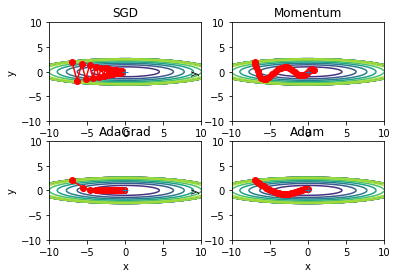

In [11]:
# coding: utf-8
import sys, os
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/')

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

===========iteration:0===========
SGD:2.363520999264246
Momentum:2.4537131584754874
AdaGrad:1.8813995669296781
Adam:2.1343349455595564
===========iteration:100===========
SGD:1.7445660077720966
Momentum:0.36544155718360893
AdaGrad:0.10927832925753485
Adam:0.21242005662500946
===========iteration:200===========
SGD:0.847389611331852
Momentum:0.16636065706815253
AdaGrad:0.0813153977490631
Adam:0.11372647733321184
===========iteration:300===========
SGD:0.5636714297171933
Momentum:0.15965239005753507
AdaGrad:0.04444288102437197
Adam:0.07642561853018835
===========iteration:400===========
SGD:0.5121914647285877
Momentum:0.19473959283744252
AdaGrad:0.06285478159354599
Adam:0.12257937358266077
===========iteration:500===========
SGD:0.40443943667048055
Momentum:0.13110584323160746
AdaGrad:0.041496101937588833
Adam:0.08164429500626957
===========iteration:600===========
SGD:0.47118895242664677
Momentum:0.14865824136917197
AdaGrad:0.06614363646630043
Adam:0.14265134344678299
===========iterati

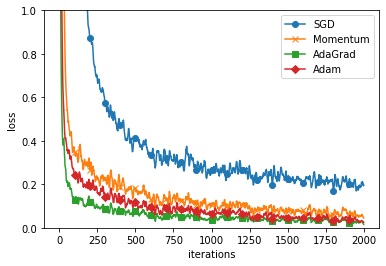

In [13]:
# coding: utf-8
import sys, os
sys.path.insert(0, '/content/gdrive/My Drive/')

# 부모 디렉터리의 파일을 가져올 수 있도록 설정

import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 6.2 가중치의 초깃값

신경망 학습에서 특히 중요한 것이 가중치의 초깃값입니다. 가중치의 초깃값을 무엇으로 설정하느냐가 신경망 학습의 성패가 가르는 일이 실제로 자주 있습니다. 이번 절에서는 권장 초깃값에 대해서 설명하고 실험을 통해 실제로 신경망 학습이 신속하게 이뤄지는 모습을 확인하겠습니다.

## 6.2.1 초깃값을 0 으로 하면?

## 6.2.2 은닉층의 활성화값 분포

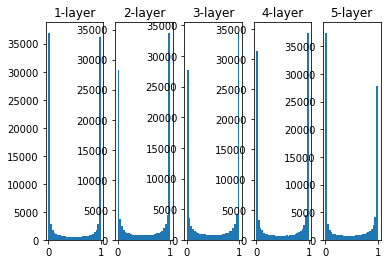

In [19]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

 
x = np.random.randn(1000, 100)  # 1000개의 데이터중에서 100개를 랜덤으로 뽑는다. 각 층의 뉴런은 100개씩.
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장


for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    # i 가 은닉층에 범위 안에 있다면 -1 씩 해보면서 넣어보자.
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1 # 가중치의 표준편차를 1로 설정
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

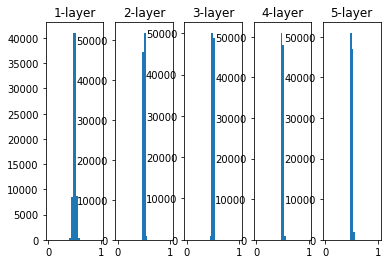

In [23]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

 
x = np.random.randn(1000, 100)  # 1000개의 데이터중에서 100개를 랜덤으로 뽑는다. 각 층의 뉴런은 100개씩.
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장


for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    # i 가 은닉층에 범위 안에 있다면 -1 씩 해보면서 넣어보자.
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 0.01 #가중치의 표준편차를 0.01로 실험
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

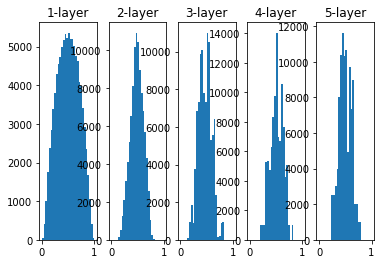

In [24]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

 
x = np.random.randn(1000, 100)  # 1000개의 데이터중에서 100개를 랜덤으로 뽑는다. 각 층의 뉴런은 100개씩.
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장


for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    # i 가 은닉층에 범위 안에 있다면 -1 씩 해보면서 넣어보자.
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #가중치를 Xavier초깃값으로 실험
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

## 6.2.3 ReLu를 사용할때 가중치 초깃값

책 그림 참고

## 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

===========iteration:0===========
std=0.01:2.30252193814334
Xavier:2.3219038651543995
He:2.3817134706165777
===========iteration:100===========
std=0.01:2.3022412723786125
Xavier:2.257200946123625
He:1.5627244584370077
===========iteration:200===========
std=0.01:2.3011334207760545
Xavier:2.1180827775054794
He:0.8176914766339969
===========iteration:300===========
std=0.01:2.3030039452435203
Xavier:1.8094331972413074
He:0.5969764954511592
===========iteration:400===========
std=0.01:2.301950704884343
Xavier:1.3208877289612728
He:0.3892464635624232
===========iteration:500===========
std=0.01:2.303459557585668
Xavier:0.9626314477417859
He:0.4654491285617321
===========iteration:600===========
std=0.01:2.302565588348685
Xavier:0.6207403191731495
He:0.24101288625739895
===========iteration:700===========
std=0.01:2.3029906497823003
Xavier:0.6271641660283578
He:0.3417370173970331
===========iteration:800===========
std=0.01:2.3008130508443254
Xavier:0.46125628025871745
He:0.242138828310246

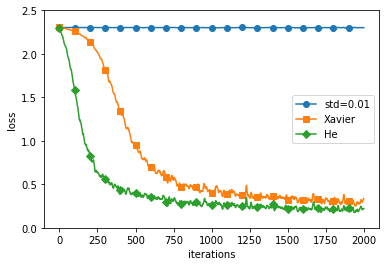

In [25]:
# coding: utf-8
import sys, os
sys.path.insert(0, '/content/gdrive/My Drive/') # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128 #배치 사이즈 128
max_iterations = 2000 #학습의 반복획수 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'} # 가중치를 std=0.01 일때 , xavier 초깃값, he 초깃값을 넣는다.
optimizer = SGD(lr=0.01) #학습률을 0.01로 설정

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()